# Show fmtn var explained vs num PCs kept, vs PCA explained variance ratios

Result is model neural dynamics are nearly 1-dim, but need to keep several more to explain behav variance.

Suggests that have much additional behav info in small variations around low-dim neural signal.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_plot, set_color
from my_torch import skl_fit_ridge
from my_stats import nanpearsonr

from record_0_main import smlt_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

ALPHA = 10

In [2]:
LOAD_DIR = f'data/simple/mlv/ma_het_tau_a_vary_pc'
FPFX = 'ma_het_tau_a_npc'

In [3]:
fnames = [fname for fname in os.listdir(LOAD_DIR) if fname.startswith(FPFX)]

In [4]:
npcs = [int(fname[len(FPFX)+1:-4]) for fname in fnames]

fnames = np.array(fnames)[np.argsort(npcs)]
npcs = sorted(npcs)

r2_test_mns = {targ: [] for targ in TARGS}
r2_test_sds = {targ: [] for targ in TARGS}
r2_test_maxs = {targ: [] for targ in TARGS}

ws = {targ: [] for targ in TARGS}
pcs = []

for fname in fnames:
    
    data = np.load(os.path.join(LOAD_DIR, fname), allow_pickle=True)[0]
    r2_trains = data['R2_TRAINS']
    r2_tests = data['R2_TESTS']
    
    for targ in TARGS:
        r2_test_mns[targ].append(np.mean(r2_tests[targ]))
        r2_test_sds[targ].append(np.std(r2_tests[targ]))
        r2_test_maxs[targ].append(np.max(r2_tests[targ]))
        
        try:
            ws[targ].append(data['WS'][targ])
        except:
            pass
        
    try:
        pcs.append(data['PCS'])
    except:
        pass

# Compute PCs of fast-adapt, slow-integrate ppln

In [5]:
# SPECIFY STRAINS USED
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

In [6]:
# record activity on the fly
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_trs = [df_behav[df_behav.ID == i] for i in ISTRAIN]
df_behav = None

In [7]:
N = 20

rtau_r = [120, 120]
rtau_a = [.1, 2]

tau_rs = np.random.uniform(*rtau_r, N)
tau_as = np.random.uniform(*rtau_a, N)
x_ss = np.random.uniform(0, 1, N)
x_ps = 1 - x_ss

params = {'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps}

In [8]:
rs_20_mas = []

for df_tr in df_trs:
    t = np.array(df_tr['T'])
    
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    b = np.zeros(len(t), dtype=int)
    b[i_s == 1] = 1
    b[i_p == 1] = 2

    # simulate population response
    rs_20_ma = smlt_ma(i_s, i_p, params, DT)
    sys.stdout.write('.')
    
    rs_20_mas.append(rs_20_ma)
    
rs_20_ma_all = cc(rs_20_mas, axis=0)

.......................................................................................

In [9]:
pca_20 = decomposition.PCA().fit(rs_20_ma_all)
var_exp_ma_20 = pca_20.explained_variance_ratio_

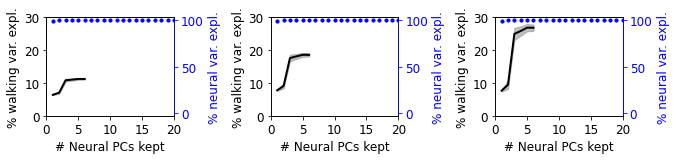

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(9.5, 2.25), tight_layout=True)
for targ, ax in zip(TARGS, axs):
    mns = 100*np.array(r2_test_mns[targ])
    sds = 100*np.array(r2_test_sds[targ])
    ax.errorbar(npcs, mns, c='k', lw=2)
    ax.fill_between(npcs, mns-sds, mns+sds, color='gray', alpha=.5)
    ax.set_ylim(bottom=0)
    
    ax_twin = ax.twinx()
    ax_twin.scatter(np.arange(20)+1, 100*var_exp_ma_20.cumsum(), c='b', s=10)
    ax_twin.set_ylim(-3, 103)
    set_plot(ax_twin, y_label='% neural var. expl.')
    set_color(ax_twin, 'b')
    
for ax in axs:
    set_plot(ax, x_lim=(0, 20), y_lim=(0, 30), x_label='# Neural PCs kept', y_label=r'% walking var. expl.', font_size=12)
    
# fig.savefig('ms/fig_2f.svg')

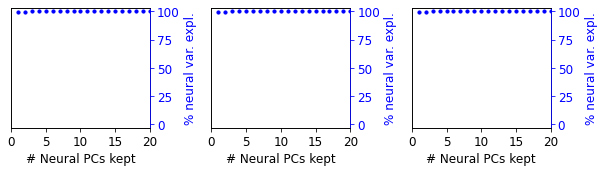

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 2.5), tight_layout=True)
for targ, ax in zip(TARGS, axs):
#     mns = 100*np.array(r2_test_mns[targ])
#     sds = 100*np.array(r2_test_sds[targ])
#     ax.errorbar(npcs, mns, c='k', lw=2)
#     ax.fill_between(npcs, mns-sds, mns+sds, color='gray', alpha=.5)
    ax.set_ylim(bottom=0)
    
    ax_twin = ax.twinx()
    ax_twin.scatter(np.arange(20)+1, 100*var_exp_ma_20.cumsum(), c='b', s=10)
    ax_twin.set_ylim(-3, 103)
    set_plot(ax_twin, y_label='% neural var. expl.')
    set_color(ax_twin, 'b')
    
for ax in axs:
    set_plot(ax, y_ticks=[], x_lim=(0, 20), x_label='# Neural PCs kept', font_size=12)
    

# Analyze top PC

In [11]:
pc_1s_aligned = []
ws_aligned = {targ: [] for targ in TARGS}

for cppln, pcs_ in enumerate(pcs[0]):
    pc_1 = pcs_[0, :]
    if np.mean(pc_1) < 0:
        pc_1s_aligned.append(-pc_1)
        for targ in TARGS:
            temp = np.mean(ws[targ][0][cppln])
            ws_aligned[targ].append(-temp)
    else:
        pc_1s_aligned.append(pc_1.copy())
        for targ in TARGS:
            temp = np.mean(ws[targ][0][cppln])
            ws_aligned[targ].append(temp)

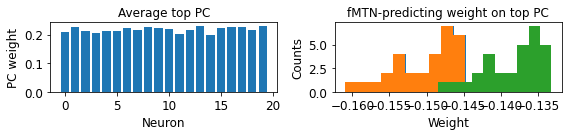

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2), tight_layout=True)
pc_1_mn = np.mean(pc_1s_aligned, 0)
axs[0].bar(range(len(pc_1_mn)), pc_1_mn)
set_plot(axs[0], x_label='Neuron', y_label='PC weight', title='Average top PC')

for targ in TARGS:
    axs[1].hist(ws_aligned[targ])
    
set_plot(axs[1], x_label='Weight', y_label='Counts', title='fMTN-predicting weight on top PC')

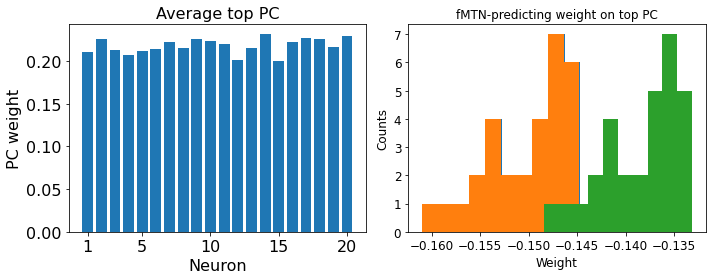

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
pc_1_mn = np.mean(pc_1s_aligned, 0)
axs[0].bar(1+np.arange(len(pc_1_mn)), pc_1_mn)
set_plot(axs[0], x_ticks=[1, 5, 10, 15, 20], x_label='Neuron', y_label='PC weight', title='Average top PC', font_size=16)

for targ in TARGS:
    axs[1].hist(ws_aligned[targ])
    
set_plot(axs[1], x_label='Weight', y_label='Counts', title='fMTN-predicting weight on top PC')

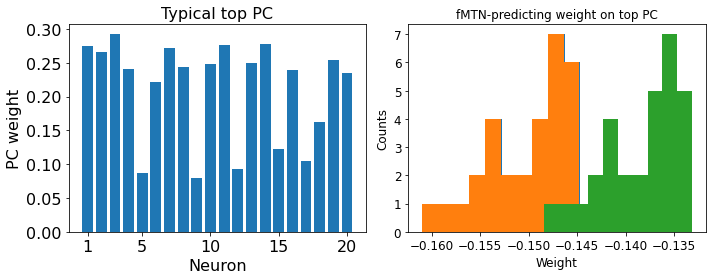

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
pc_1_typ = pc_1s_aligned[5]
axs[0].bar(1+np.arange(len(pc_1_typ)), pc_1_typ)
set_plot(axs[0], x_ticks=[1, 5, 10, 15, 20], x_label='Neuron', y_label='PC weight', title='Typical top PC', font_size=16)

for targ in TARGS:
    axs[1].hist(ws_aligned[targ])
    
set_plot(axs[1], x_label='Weight', y_label='Counts', title='fMTN-predicting weight on top PC')